In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# import selenium
# from selenium import webdriver

In [34]:
url = 'https://opendata-geohive.hub.arcgis.com/datasets/d8eb52d56273413b84b0187a4e9117be_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'
import pandas as pd
df2 = pd.read_csv(url)
print(df2.head())
print(df2.shape)
print(df2.columns)
ending = df2.shape[0] - 1

               X             Y  ... Aged75to84  Aged85up
0 -856335.869598  7.036492e+06  ...        NaN       NaN
1 -856335.869598  7.036492e+06  ...        NaN       NaN
2 -856335.869598  7.036492e+06  ...        0.0       0.0
3 -856335.869598  7.036492e+06  ...        0.0       0.0
4 -856335.869598  7.036492e+06  ...        0.0       0.0

[5 rows x 41 columns]
(644, 41)
Index(['X', 'Y', 'Date', 'ConfirmedCovidCases', 'TotalConfirmedCovidCases',
       'ConfirmedCovidDeaths', 'TotalCovidDeaths', 'StatisticsProfileDate',
       'CovidCasesConfirmed', 'HospitalisedCovidCases',
       'RequiringICUCovidCases', 'HealthcareWorkersCovidCases',
       'ClustersNotified', 'HospitalisedAged5', 'HospitalisedAged5to14',
       'HospitalisedAged15to24', 'HospitalisedAged25to34',
       'HospitalisedAged35to44', 'HospitalisedAged45to54',
       'HospitalisedAged55to64', 'Male', 'Female', 'Unknown', 'Aged1to4',
       'Aged5to14', 'Aged15to24', 'Aged25to34', 'Aged35to44', 'Aged45to54',
       'Aged

In [35]:
print(df2['Date'])

0      2020/02/29 00:00:00+00
1      2020/03/03 00:00:00+00
2      2020/03/04 00:00:00+00
3      2020/03/05 00:00:00+00
4      2020/03/06 00:00:00+00
                ...          
639    2021/12/01 00:00:00+00
640    2021/12/02 00:00:00+00
641    2021/12/03 00:00:00+00
642    2021/12/04 00:00:00+00
643    2021/12/05 00:00:00+00
Name: Date, Length: 644, dtype: object


new_hcc:  42
new_icu_hcc:  44


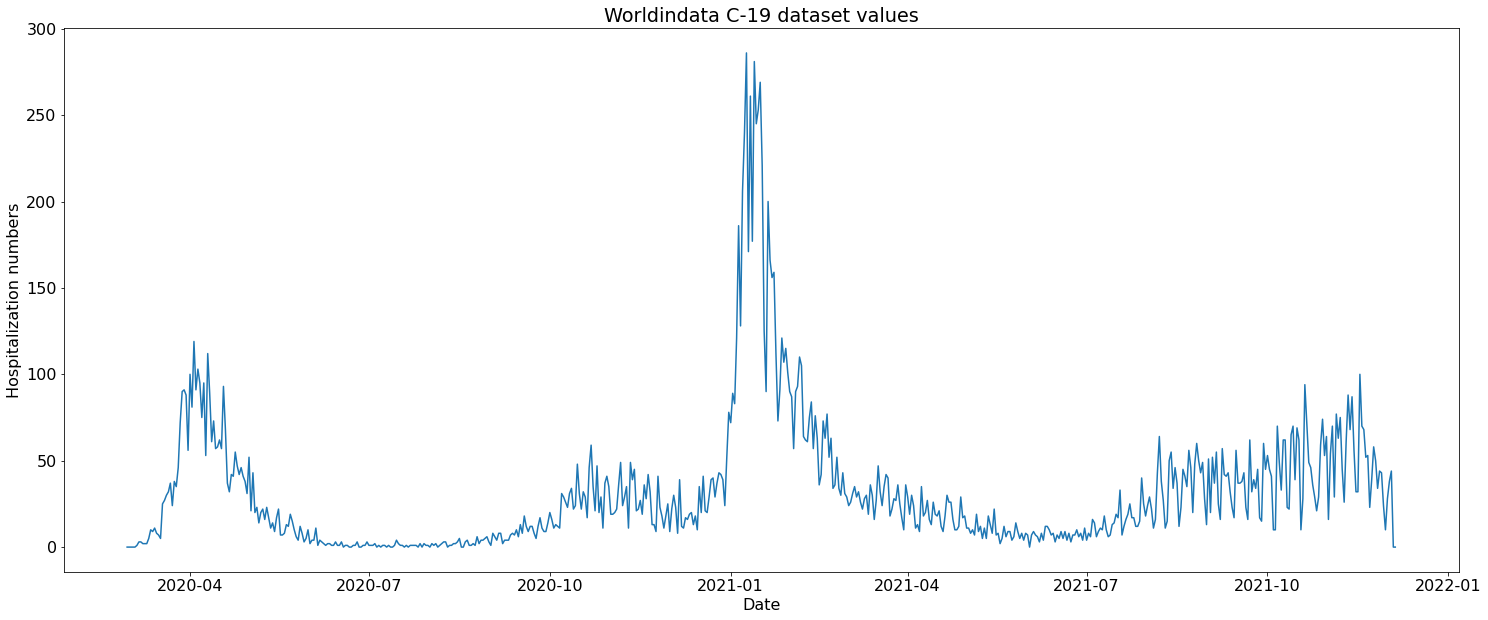

In [36]:
def data_preprocess():
  df2['Date'] = pd.to_datetime(df2['Date']).dt.date
  df2['HCC'] = df2['HospitalisedCovidCases'].fillna(0)

  # for index, row in df2.iterrows():
  #     print(index, row['Date'], row['HCC'])

  # d = df2['Date'][0]
  prev_num = 0
  df2['new_HCC'] = df2['HCC']
  for index,row in df2.iterrows():
    df2.at[index, 'new_HCC'] = row['HCC'] - prev_num
    prev_num = row['HCC']

  plt.plot(df2['Date'], df2['new_HCC'])
  plt.xlabel('Date')
  plt.ylabel('Hospitalization numbers')
  plt.title('Worldindata C-19 dataset values')

  df2['ICU_HCC'] = df2['RequiringICUCovidCases'].fillna(0)
  prev_num = 0
  for index,row in df2.iterrows():
    df2.at[index, 'new_ICU_HCC'] = row['ICU_HCC'] - prev_num
    prev_num = row['ICU_HCC']

  print("new_hcc: ",df2.columns.get_loc('new_HCC'))
  print("new_icu_hcc: ",df2.columns.get_loc('new_ICU_HCC'))

data_preprocess()


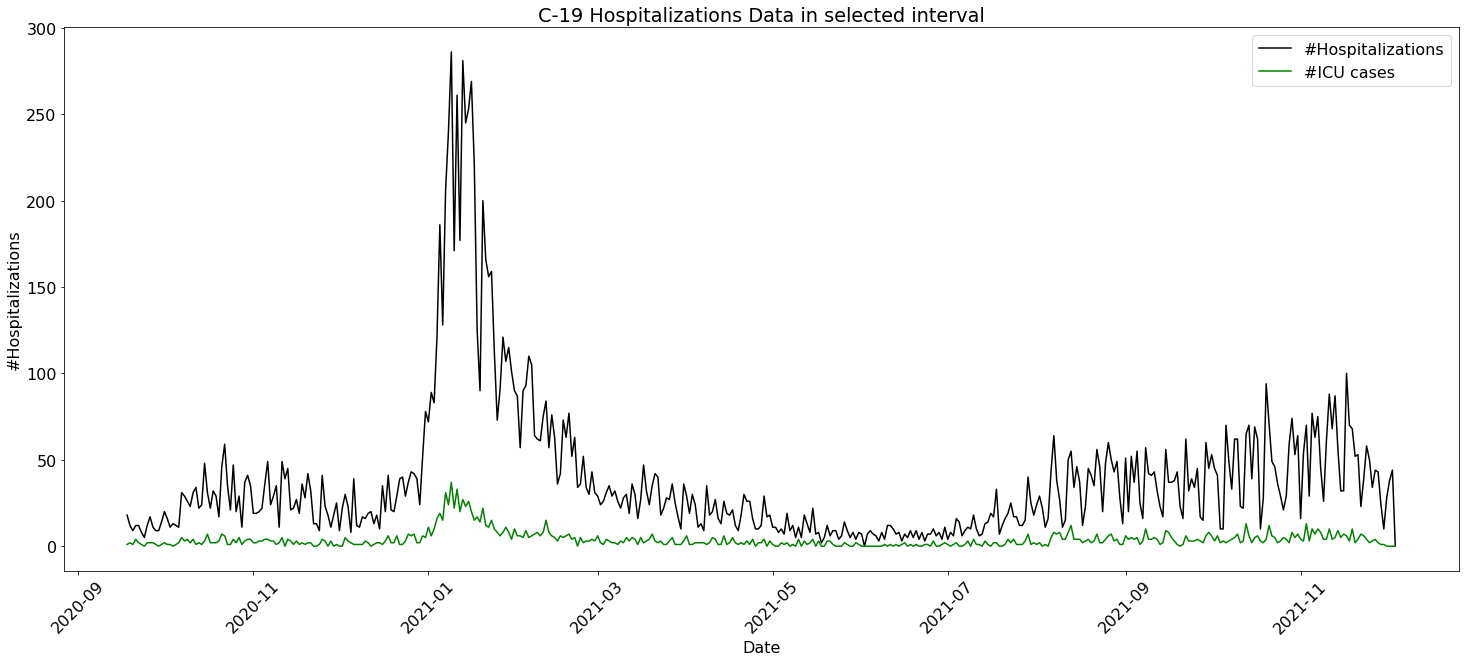

In [37]:

plt.rcParams.update({'font.size': 16})
plt.plot(df2.iloc[200:ending,2], df2.iloc[200:ending,42], color='black', label='#Hospitalizations')
plt.plot(df2.iloc[200:ending,2], df2.iloc[200:ending,44], color='green', label='#ICU cases')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('#Hospitalizations')
plt.legend()
plt.title('C-19 Hospitalizations Data in selected interval')
plt.show()

In [38]:
def feature_selection(i1, i2):
  start=pd.to_datetime(df2['Date'][i1])
  print("Start: ", start)
  end=pd.to_datetime(df2['Date'][i2])
  print("End: ", end)
  t_full=pd.array(pd.DatetimeIndex(df2.iloc[i1:i2,2])).astype(np.int64)
  # print("Tfull: ", t_full)
  dt = t_full[2] - t_full[1] 
  print("Data sampling interval", dt)
  t = (t_full[i1+3]-t_full[i1+2])/60/60/24
  print(t)
  ss = pd.array(pd.Index(df2.iloc[i1:i2,42])).astype(np.int64) #42nd column is Hospitalization number
  og_ss = ss
  print(og_ss.size)
  # plt.plot(df2.iloc[i1:i2, 2], ss, color='black')
  # plt.xlabel('Date')
  # plt.ylabel('#C-19 Hospitalisations')
  # plt.title('#C-19 Hospitalisation Cases in selected interval')
  # plt.show()
  return (t_full, og_ss, ss)

In [39]:
def feature_selection_ICU(i1, i2):
  start=pd.to_datetime(df2['Date'][i1])
  print("Start: ", start)
  end=pd.to_datetime(df2['Date'][i2])
  print("End: ", end)
  t_full=pd.array(pd.DatetimeIndex(df2.iloc[i1:i2,2])).astype(np.int64)
  # print("Tfull: ", t_full)
  dt = t_full[2] - t_full[1] 
  print("Data sampling interval", dt)
  t = (t_full[i1+3]-t_full[i1+2])/60/60/24
  print(t)
  icu_ss = pd.array(pd.Index(df2.iloc[i1:i2,44])).astype(np.int64) #42nd column is Hospitalization number
  icu_og_ss = icu_ss
  # plt.plot(df2.iloc[i1:i2, 2], icu_ss, color='green')
  # plt.xlabel('Date')
  # plt.ylabel('#C-19 ICU Cases')
  # plt.title('#C-19 ICU Cases in selected interval')
  # plt.show()
  return (t_full, icu_og_ss, icu_ss)

Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443


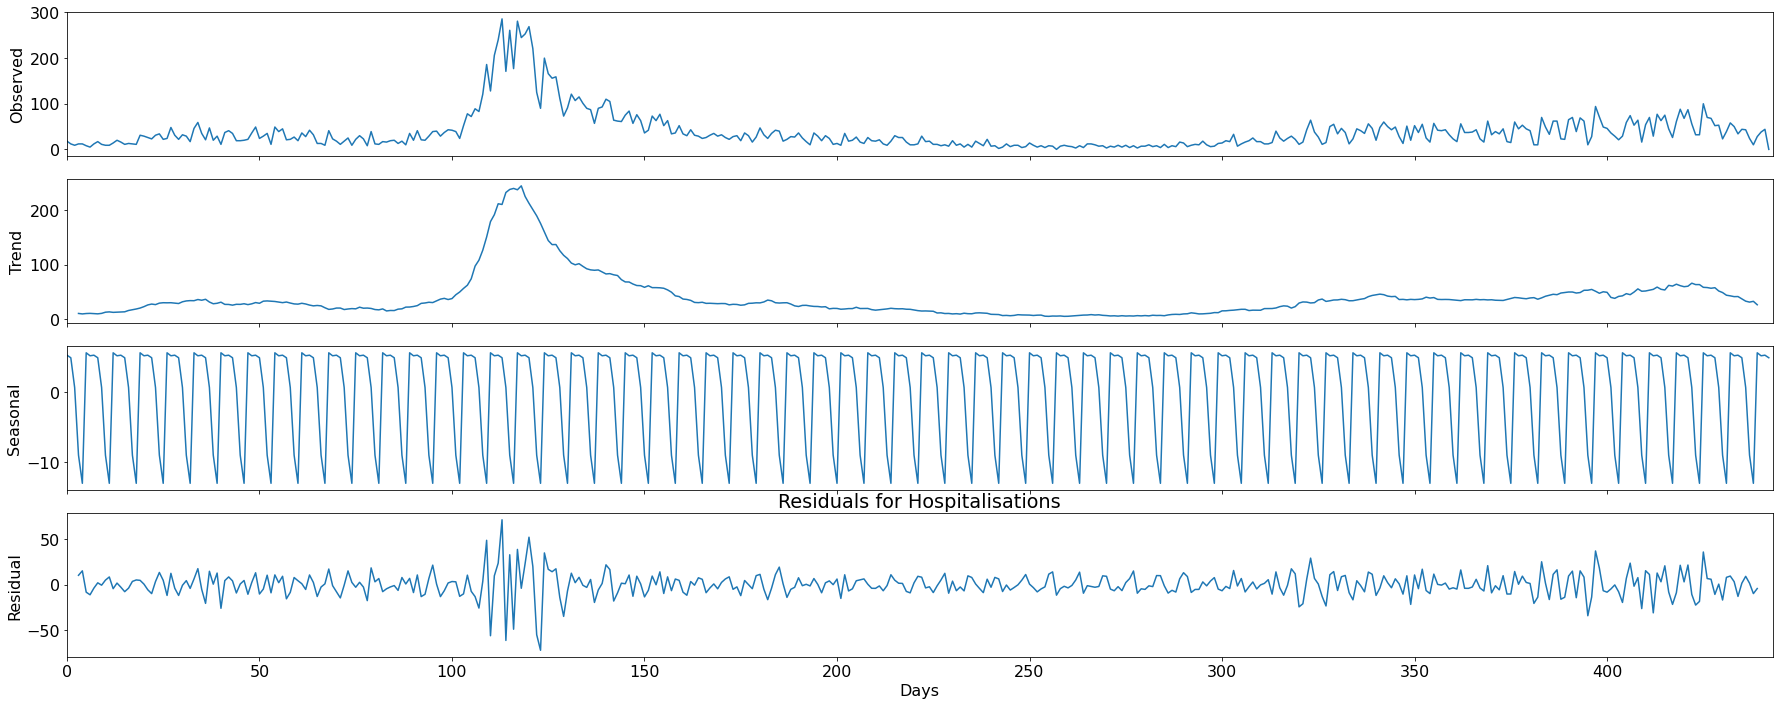

In [40]:
(t, og_ss,ss) = feature_selection(200, ending)
period = 7
result = seasonal_decompose(ss, model='additive', freq=period)
plt.rcParams["figure.figsize"] = (25,10)
result.plot()
plt.title('Residuals for Hospitalisations')
plt.xlabel('Days')
plt.show()

Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0


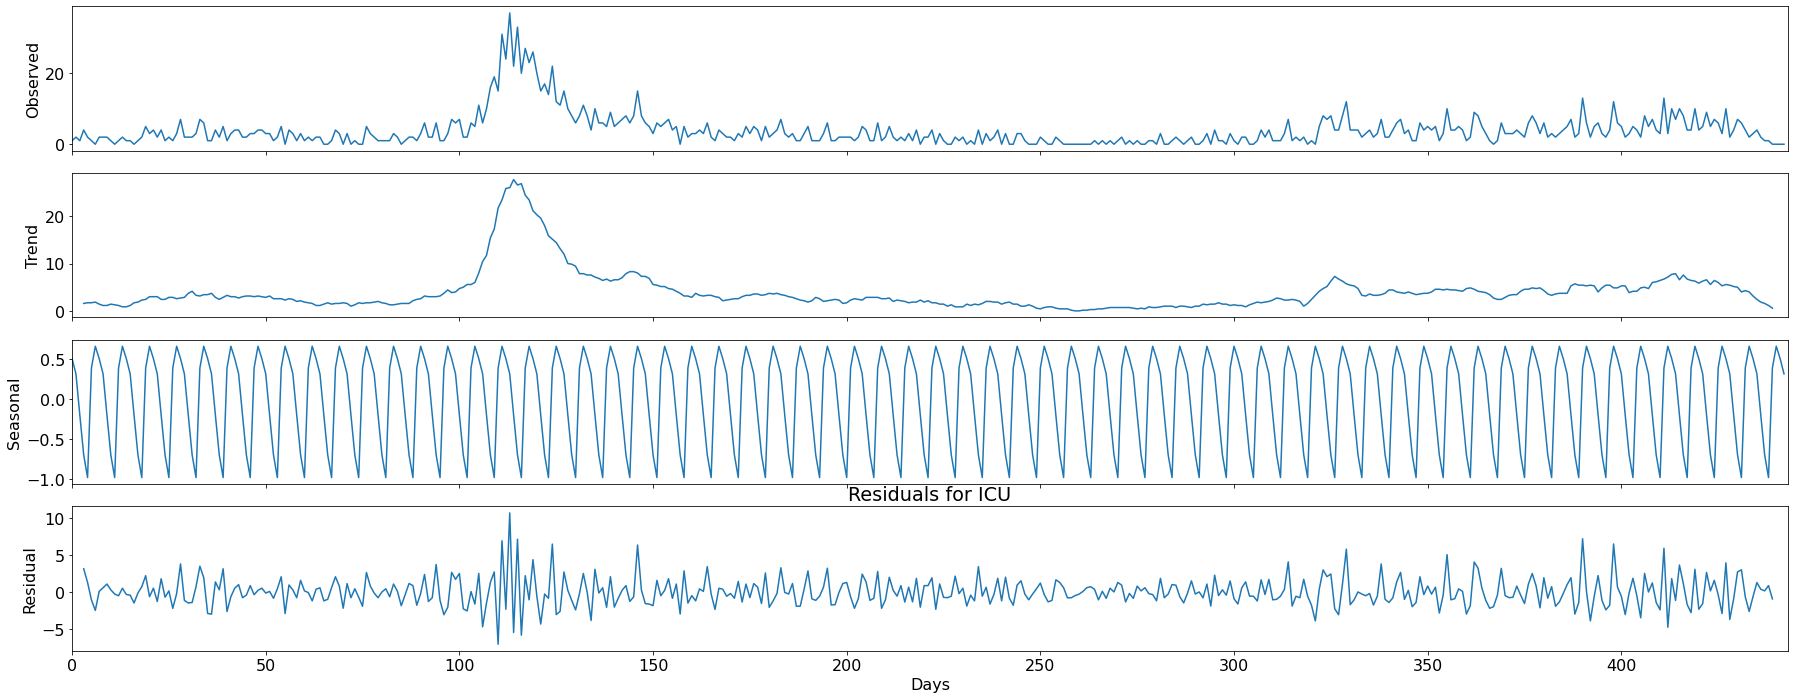

In [32]:
(t, og_ss,ss) = feature_selection_ICU(200, ending)
period = 7
result = seasonal_decompose(ss, model='additive', freq=period)
plt.rcParams["figure.figsize"] = (25,10)
result.plot()
plt.title('Residuals for ICU')
plt.xlabel('Days')
plt.show()

In [13]:
def choose_index_train(i1, i2, model_name, hyperparameter):  
  (t_full, og_ss, ss) = feature_selection(200, ending)

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]
    # print(tt.size)
  train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

  if(model_name == 'Lasso'):
    model = Lasso(fit_intercept=False, alpha=hyperparameter).fit(XX[train], yy[train]) 
  elif(model_name == 'Ridge'):
    model = Ridge(fit_intercept=False, alpha=hyperparameter).fit(XX[train], yy[train])
  elif(model_name == 'LR'):
    model = LogisticRegression(fit_intercept=True, penalty='l2').fit(XX[train], yy[train]) 
  elif(model_name == 'SVM'):
    model = SVR(C=50).fit(XX[train], yy[train]) 

  y_pred = model.predict(XX) 

  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='black', label='Training values')
  tt_dates = pd.to_datetime(t_full)
  plt.plot(tt, y_pred, color='blue', label='Predicted values')
  plt.xticks(t_full, labels=tt_dates, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.xlabel('Date')
  plt.ylabel('#Hospitalizations')
  plt.title('C-19 #Hospitalizations Data between selected interval')
  plt.legend()
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred)
  rmse = math.sqrt(mse)
  print("Hospitalisation# rmse:", rmse)



In [14]:
def choose_index_train_ICU(i1, i2, model_name, hyperparameter):  
  (t_full, og_ss, ss) = feature_selection_ICU(i1, i2)
  # plt.plot(df2.iloc[i1:i2, 2], ss, color='black')
  # plt.show()

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]
    # print(tt.size)
  train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

  if(model_name == 'Lasso'):
    model = Lasso(fit_intercept=False, alpha=hyperparameter).fit(XX[train], yy[train]) 
  elif(model_name == 'Ridge'):
    model = Ridge(fit_intercept=False, alpha=hyperparameter).fit(XX[train], yy[train])
  elif(model_name == 'LR'):
    model = LogisticRegression(fit_intercept=True, penalty='l2').fit(XX[train], yy[train]) 
  elif(model_name == 'SVM'):
    model = SVR(C=50).fit(XX[train], yy[train]) 

  y_pred = model.predict(XX) 

  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='green', label='Training values')
  tt_dates = pd.to_datetime(t_full)
  plt.plot(tt, y_pred, color='orange', label='Predicted values')
  plt.xticks(t_full, labels=tt_dates, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.xlabel('Date')
  plt.ylabel('#Hospitalizations')
  plt.title('C-19 #ICU Data between selected interval')
  plt.legend()
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred)
  rmse = math.sqrt(mse)
  print("ICU# rmse:", rmse)



Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443


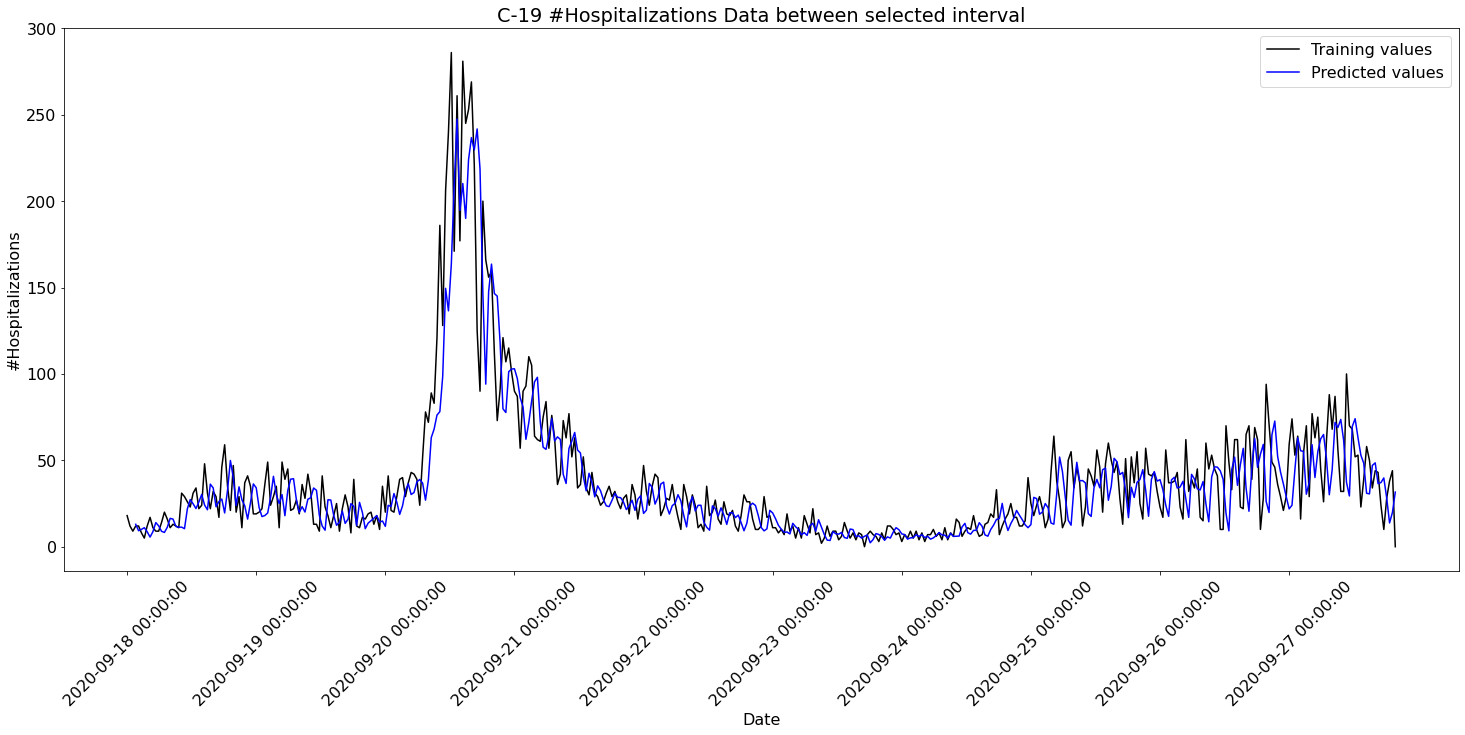

Hospitalisation# rmse: 22.64703664372644
Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0


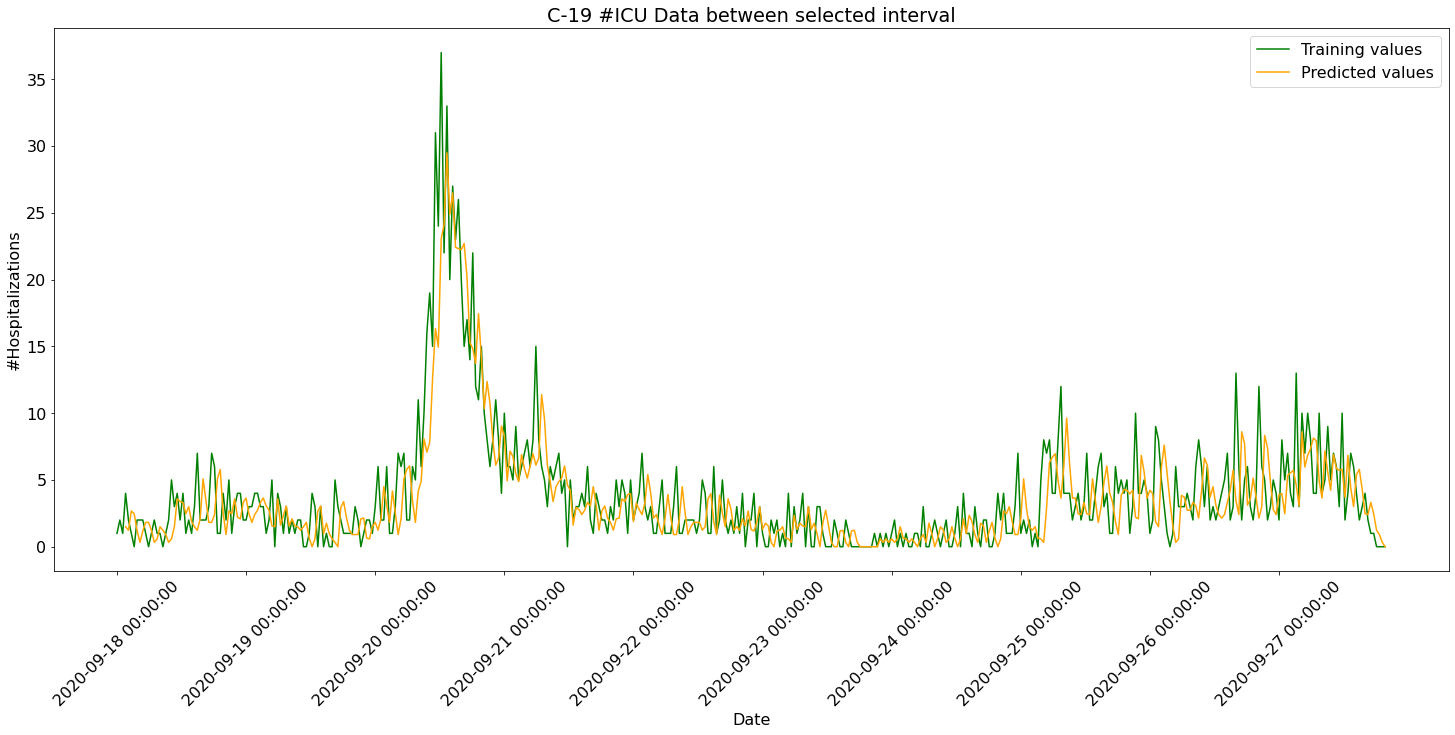

ICU# rmse: 2.8615812333957336


In [15]:
choose_index_train(200,ending,'Ridge', 0.1)
choose_index_train_ICU(200,ending, 'Ridge', 0.1)

Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.180e+04, tolerance: 1.150e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, posi

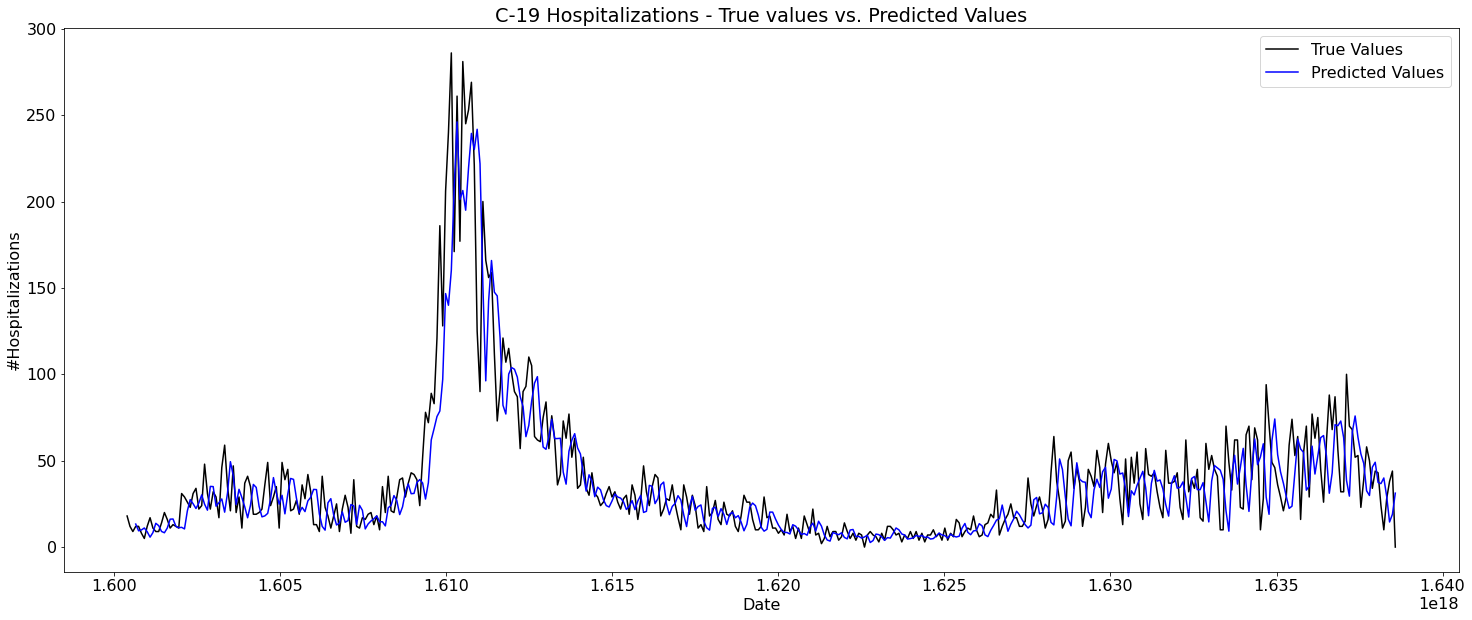

mse: 22.63249796705541


In [17]:
stride = 1
lag = 2 #determines the feature vector size
dd = 1 #number of samples in a day 
q = 1
(t_full, og_ss, ss) = feature_selection(200, ending)
XX = og_ss[0:og_ss.size - q - lag * dd:stride]
for i in range(1,lag): 
  X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
  XX = np.column_stack((XX,X))
  # print(XX.size) #will be size = lag * X_size
yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
# print("SS:",ss.size)
# print("yy:",yy.size)
tt = t_full[lag*dd+q::stride]
  # print(tt.size)
from sklearn.model_selection import train_test_split 
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
model = Lasso(fit_intercept=False, alpha=0).fit(XX[train], yy[train]) 
  # print(model.intercept_, model.coef_)

y_pred = model.predict(XX) 

plt.rcParams["figure.figsize"] = (25,10)
plt.plot(t_full, og_ss, color='black', label='True Values')
plt.plot(tt, y_pred, color='blue', label='Predicted Values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('#Hospitalizations')
plt.title('C-19 Hospitalizations - True values vs. Predicted Values')
plt.show()

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(yy, y_pred)
rmse = math.sqrt(mse)
print("mse:", rmse)



Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443
[5279.978046997779, 165.24374288124702, 37.827058492026325, 322.01929464457805, 773.7877539997894]
[0.014085864089309542, 4.813367373052122e-05, 0.00018444902714120884, 0.00010858933910384739, 0.0001825636664640096]


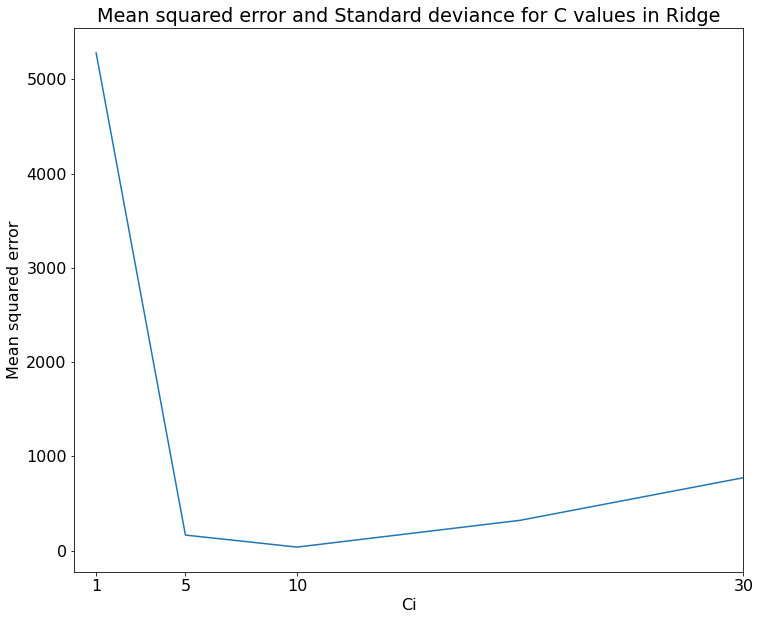

Ridge best C:  10  , Ridge rmse:  6.150370597941747


In [18]:
def Ridge_Performance(i1, i2):
  (t_full, ss, og_ss) = feature_selection(i1, i2)

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]

  tscv = TimeSeriesSplit()
  TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
  mean_error = []
  std_error = []
  C = [1, 5, 10, 20, 30]
  for train_index, test_index in tscv.split(XX):
    temp = []
    temp2 =[]
    for Ci in C:
      model = Ridge(fit_intercept=True, alpha=Ci)
      model.fit(XX[train_index], yy[train_index])
      y_pred = model.predict(XX[test_index])
      temp.append(mean_squared_error(yy[test_index], y_pred))
      temp2.append(mean_absolute_error(yy[test_index], y_pred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp2).std())
  
  plt.rcParams["figure.figsize"] = (12,10)
  plt.xlim((0, 30))
  plt.errorbar(C, mean_error, yerr=std_error)
  plt.xlabel('Ci')
  print(mean_error)
  print(std_error)
  plt.xticks([1, 5, 10, 30])
  plt.ylabel('Mean squared error')
  plt.title('Mean squared error and Standard deviance for C values in Ridge')

  plt.show()
  return (C[mean_error.index(min(mean_error))], min(mean_error))

ridge_best_c, ridge_mse = Ridge_Performance(200,ending)
print("Ridge best C: ", ridge_best_c, " , Ridge rmse: ", math.sqrt(ridge_mse))

Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443
[8689.460324116797, 168.16974924483435, 46.03302567630901, 316.74491862799357, 757.793478407666]
[9.88384620012268, 0.09765614950072003, 0.5275764951547876, 0.10003243478299899, 0.2493894541462174]


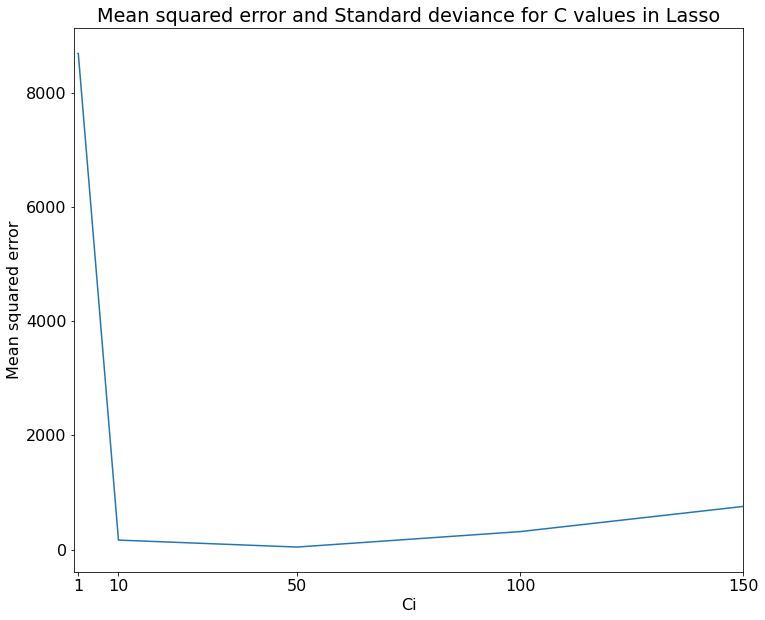

Lasso best C:  50  , Lasso rmse:  6.784764231445998


In [19]:
def Lasso_Performance(i1, i2):
  (t_full, ss, og_ss) = feature_selection(i1, i2)

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]

  tscv = TimeSeriesSplit()
  TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
  mean_error = []
  std_error = []
  C = [1, 10, 50, 100, 150]
  for train_index, test_index in tscv.split(XX):
    temp = []
    temp2 =[]
    for Ci in C:
      model = Lasso(fit_intercept=True, alpha=Ci)
      model.fit(XX[train_index], yy[train_index])
      y_pred = model.predict(XX[test_index])
      temp.append(mean_squared_error(yy[test_index], y_pred))
      temp2.append(mean_absolute_error(yy[test_index], y_pred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp2).std())
    
  plt.rcParams["figure.figsize"] = (12,10)
  plt.xlim((0, 150))
  plt.errorbar(C, mean_error, yerr=std_error)
  plt.xlabel('Ci')
  print(mean_error)
  print(std_error)
  plt.xticks(C)
  plt.ylabel('Mean squared error')
  plt.title('Mean squared error and Standard deviance for C values in Lasso')

  plt.show()
  return (C[mean_error.index(min(mean_error))], min(mean_error))
  

(lasso_best_c, lasso_mse) = Lasso_Performance(200,ending)
print("Lasso best C: ", lasso_best_c, " , Lasso rmse: ", math.sqrt(lasso_mse))

Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443
[10911.398377110407, 213.9442822705329, 307.34187143052344, 298.0199230858369, 939.6485254875463]
[41.722795281997556, 13.790833898724673, 122.65697204960301, 26.809453566486685, 56.22637076894575]


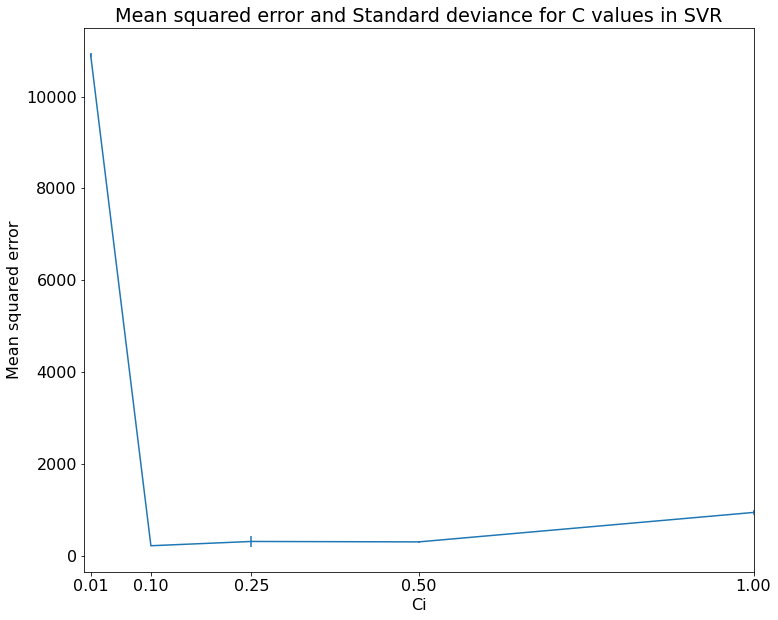

SVR best C:  0.1  , SVR rmse:  14.62683432156572


In [46]:
def SVR_Performance(i1, i2):
  (t_full, ss, og_ss) = feature_selection(i1, i2)

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]

  tscv = TimeSeriesSplit()
  TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
  mean_error = []
  std_error = []
  C = [0.01, 0.1, 0.25, 0.5, 1]
  for train_index, test_index in tscv.split(XX):
    temp = []
    temp2 =[]
    for Ci in C:
      model = SVR(C=Ci, kernel='sigmoid')
      model.fit(XX[train_index], yy[train_index])
      y_pred = model.predict(XX[test_index])
      temp.append(mean_squared_error(yy[test_index], y_pred))
      temp2.append(mean_absolute_error(yy[test_index], y_pred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())
    
  plt.rcParams["figure.figsize"] = (12,10)
  plt.xlim((0, 1))
  plt.errorbar(C, mean_error, yerr=std_error)
  plt.xlabel('Ci')
  print(mean_error)
  print(std_error)
  plt.xticks(C)
  plt.ylabel('Mean squared error')
  plt.title('Mean squared error and Standard deviance for C values in SVR')

  plt.show()
  return (C[mean_error.index(min(mean_error))], min(mean_error))
  

(svm_best_c, svr_mse) = SVR_Performance(200,ending)
print("SVR best C: ", svm_best_c, " , SVR rmse: ", math.sqrt(svr_mse))

In [22]:
# def LR_Performance(i1, i2):
#   (t_full, ss, og_ss) = feature_selection(i1, i2)

#   stride = 1
#   lag = 2 #determines the feature vector size
#   dd = 1 #number of samples in a day 
#   q = 1
#   XX = og_ss[0:og_ss.size - q - lag * dd:stride]
#   for i in range(1,lag): 
#     X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
#     XX = np.column_stack((XX,X))
#     # print(XX.size) #will be size = lag * X_size
#   yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
#   # print("SS:",ss.size)
#   # print("yy:",yy.size)
#   tt = t_full[lag*dd+q::stride]

#   tscv = TimeSeriesSplit()
#   TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
#   mean_error = []
#   std_error = []
#   C = [0.001, 0.005, 0.01, 0.1, 0.2]
#   for train_index, test_index in tscv.split(XX):
#     temp = []
#     temp2 =[]
#     for Ci in C:
#       model = LogisticRegression(fit_intercept=True, penalty='l2', max_iter=100000, C=Ci)
#       model.fit(XX[train_index], yy[train_index])
#       y_pred = model.predict(XX[test_index])
#       temp.append(mean_squared_error(yy[test_index], y_pred))
#       temp2.append(mean_absolute_error(yy[test_index], y_pred))
#     mean_error.append(np.array(temp).mean())
#     std_error.append(np.array(temp).std())
  
#   plt.rcParams["figure.figsize"] = (12,10)
#   plt.xlim((0, 0.2))
#   plt.errorbar(C, mean_error, yerr=std_error)
#   plt.xlabel('Ci')
#   print(mean_error)
#   print(std_error)
#   plt.xticks(C)
#   plt.ylabel('Mean squared error')
#   plt.title('Mean squared error and Standard deviance for C values in LogisticRegression')

#   plt.show()
#   return (C[mean_error.index(min(mean_error))], min(mean_error))
  

# (lr_best_c,lr_mse) = LR_Performance(200, ending)
# print("LR best C: ", lr_best_c, " , LR rmse: ", math.sqrt(lr_mse))

In [42]:
def LinearReg_Performance(i1, i2):
  (t_full, ss, og_ss) = feature_selection(i1, i2)

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]

  tscv = TimeSeriesSplit()
  TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
  mean_error = []
  std_error = []
  for train_index, test_index in tscv.split(XX):
    model = LinearRegression()
    model.fit(XX[train_index], yy[train_index])
    y_pred = model.predict(XX[test_index])

  mean_error = mean_squared_error(yy[test_index], y_pred)
  # plt.xlim((0, 0.2))
  # plt.errorbar(C, mean_error, yerr=std_error)
  # plt.xlabel('Ci')
  # print(mean_error)
  # print(std_error)
  # plt.xticks(C)
  # plt.ylabel('Mean squared error')
  # plt.title('Mean squared error and Standard deviance for C values in Ridge')

  # plt.show()
  return mean_error
  

linearReg_mse = LinearReg_Performance(200,ending)
print("LinearReg rmse: ", math.sqrt(linearReg_mse))

Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443
LinearReg rmse:  27.817318474871605


In [25]:
def dummy_Classifier(i1, i2):
  (t_full, ss, og_ss) = feature_selection(i1, i2)

  from sklearn.dummy import DummyRegressor
  model = DummyRegressor().fit(XX[train], yy[train])

  y_pred = model.predict(XX)

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred)
  rmse = math.sqrt(mse)

  return rmse

rmse_dummy = dummy_Classifier(200, ending)
print("RMSE dummy: ", rmse_dummy)
print("RMSE Ridge: ", math.sqrt(ridge_mse))
print("RMSE Lasso: ", math.sqrt(lasso_mse))
# print("RMSE Logistic Regression: ", math.sqrt(lr_mse))
print("RMSE Linear Regression: ", math.sqrt(linearReg_mse))
print("RMSE SVR: ", math.sqrt(svr_mse))








Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443
RMSE dummy:  43.07407380916095
RMSE Ridge:  6.150370597941747
RMSE Lasso:  6.784764231445998
RMSE Linear Regression:  27.817318474871605
RMSE SVR:  12.328332006129854


Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443


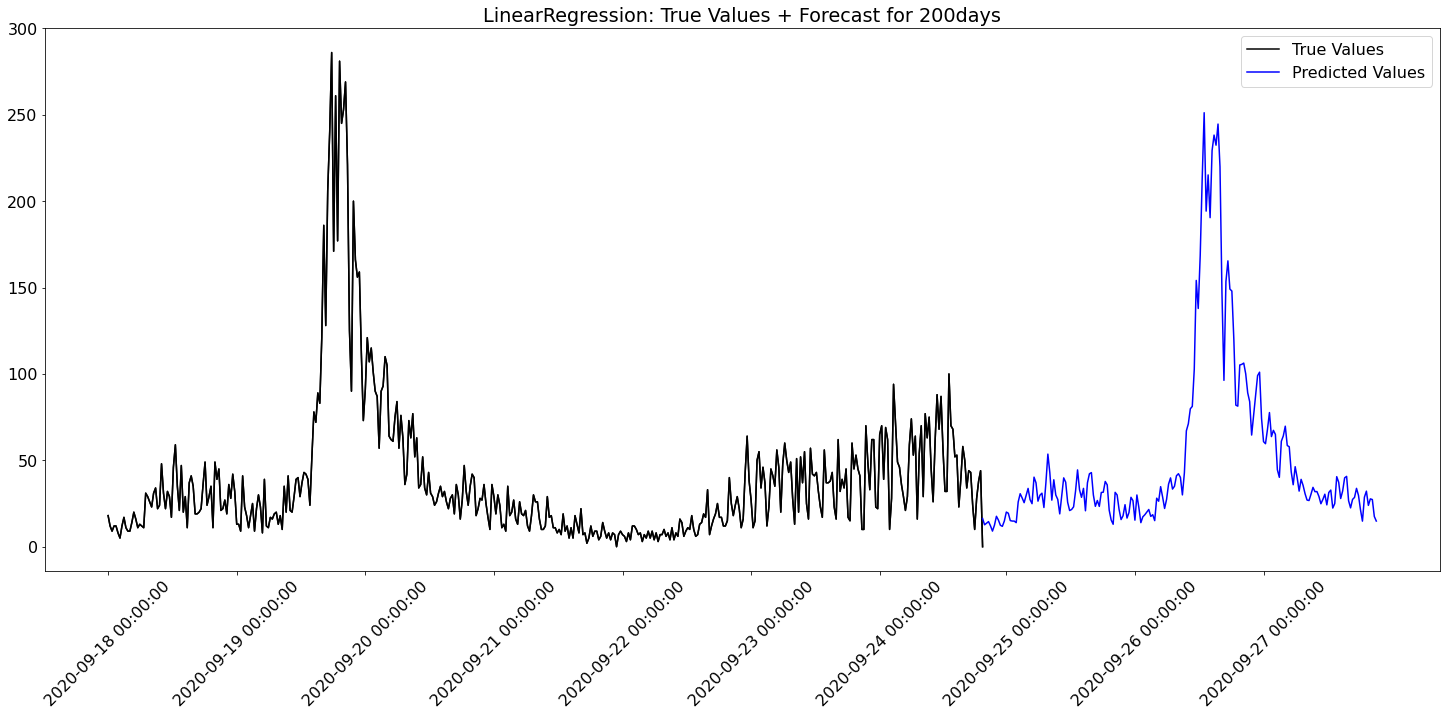

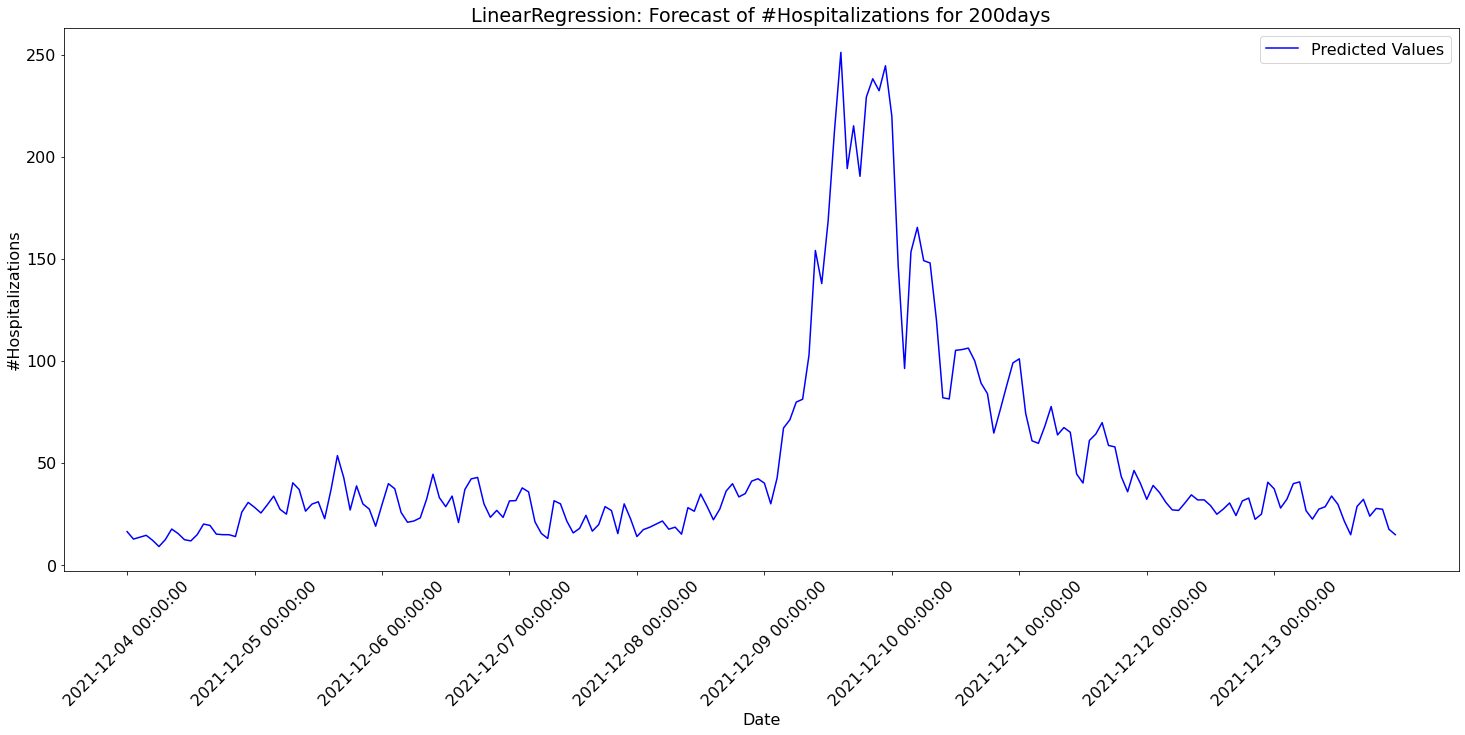

RMSE LinearRegression 200:  18.663768067556216


In [26]:
def train_predict_LinearRegression(q_step, stride, lag, dd):
  (t_full, ss, og_ss) = feature_selection(200, ending)
  
  q = 1
  ss = og_ss
  og_tt = t_full[lag*dd+q::stride]
  day_sec = t_full[2] - t_full[1]
  for j in range(0,q_step*day_sec, day_sec):
    XX = ss[0:ss.size - q - lag * dd:stride]
    for i in range(1,lag): 
      X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
      XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
    yy = ss[lag*dd+q::stride] #size of XX before column stacking
    # print("SS:",ss.size)
    # print("yy:",yy.size)
    tt = t_full[lag*dd+q::stride]
    # print(tt.size)
    from sklearn.model_selection import train_test_split 
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(XX[train], yy[train]) 
    # print(model.intercept_, model.coef_)

    y_pred = model.predict(XX) 
    yp = y_pred[y_pred.size-1]
    ss = np.append(ss, yp)
    np.append(tt, tt[tt.size-1] + day_sec)
    # print("tt:",tt.size)

  # print("XX:" ,XX.size)

  y_pred_2 = model.predict(XX)
  # print("tfull:",t_full)
  tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
  pred_num = tt_full2.size
  # print("ttfull2:",tt_full2)
  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='black')
  t_full_dates2 = pd.to_datetime(tt_full2)
  t_full_extended = np.append(t_full, tt_full2)
  t_full_dates = pd.to_datetime(t_full_extended)
  # print(t_full_dates)
  plt.plot(t_full, og_ss, color='black', label='True Values')
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue', label='Predicted Values')
  plt.xticks(t_full_extended, labels=t_full_dates, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.legend()
  plt.title('LinearRegression: True Values + Forecast for ' +str(q_step)+ 'days')
  plt.show()

  plt.plot(tt_full2, y_pred_2[:q_step], color='blue', label='Predicted Values')  
  plt.xticks(tt_full2, labels=t_full_dates2, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('#Hospitalizations')
  plt.title('LinearRegression: Forecast of #Hospitalizations for ' +str(q_step)+ 'days')
  plt.show()
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred_2)
  rmse = math.sqrt(mse)
  return rmse

rmse_linear = train_predict_LinearRegression(200, 1, 2, 1)
print("RMSE LinearRegression 200: ", rmse_linear)


Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443


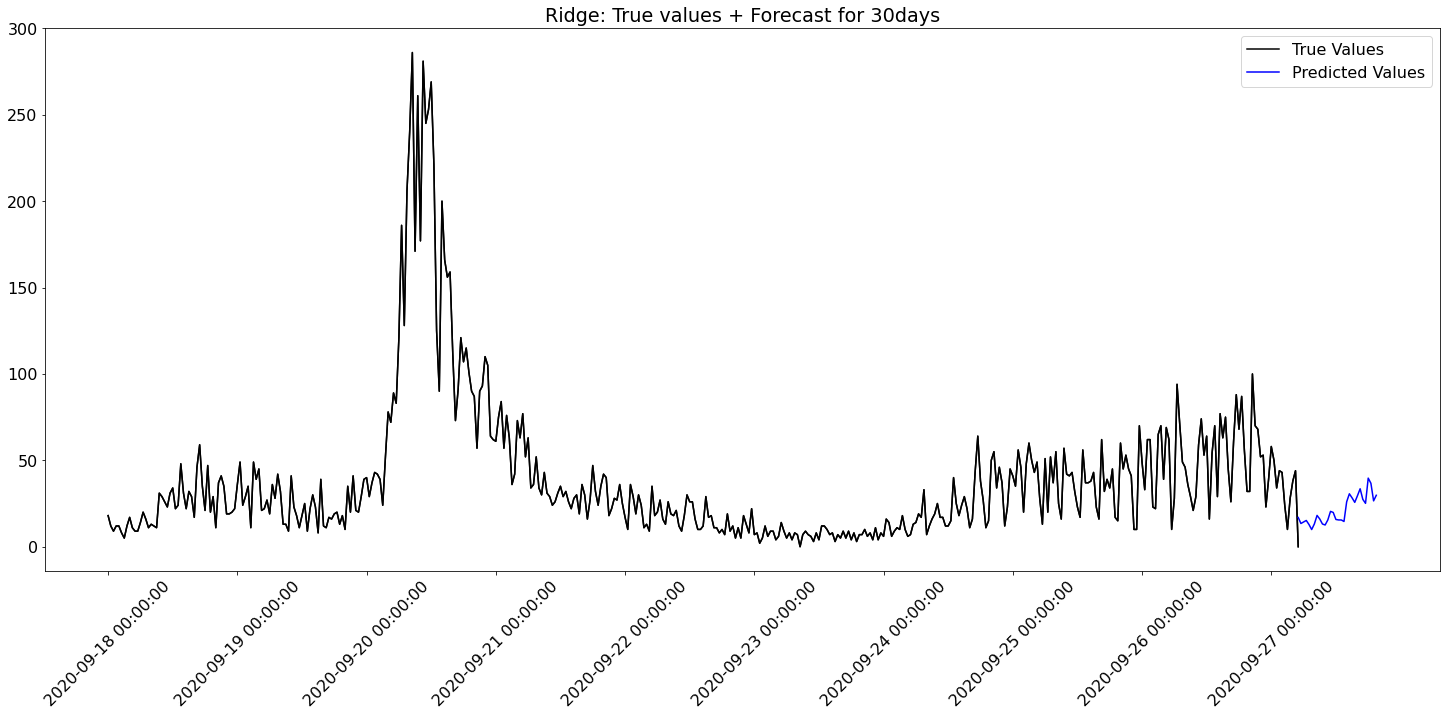

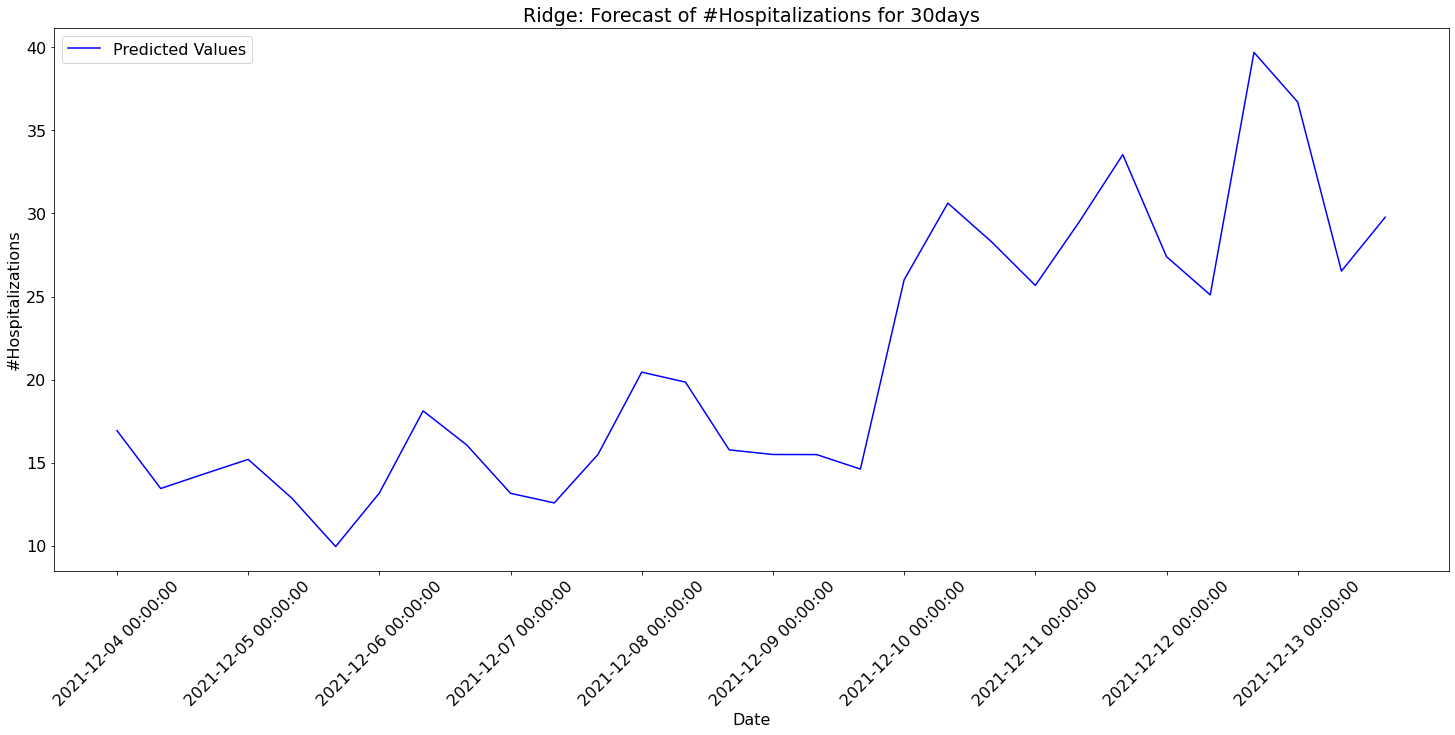

RMSE:  21.72990328215863
Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443


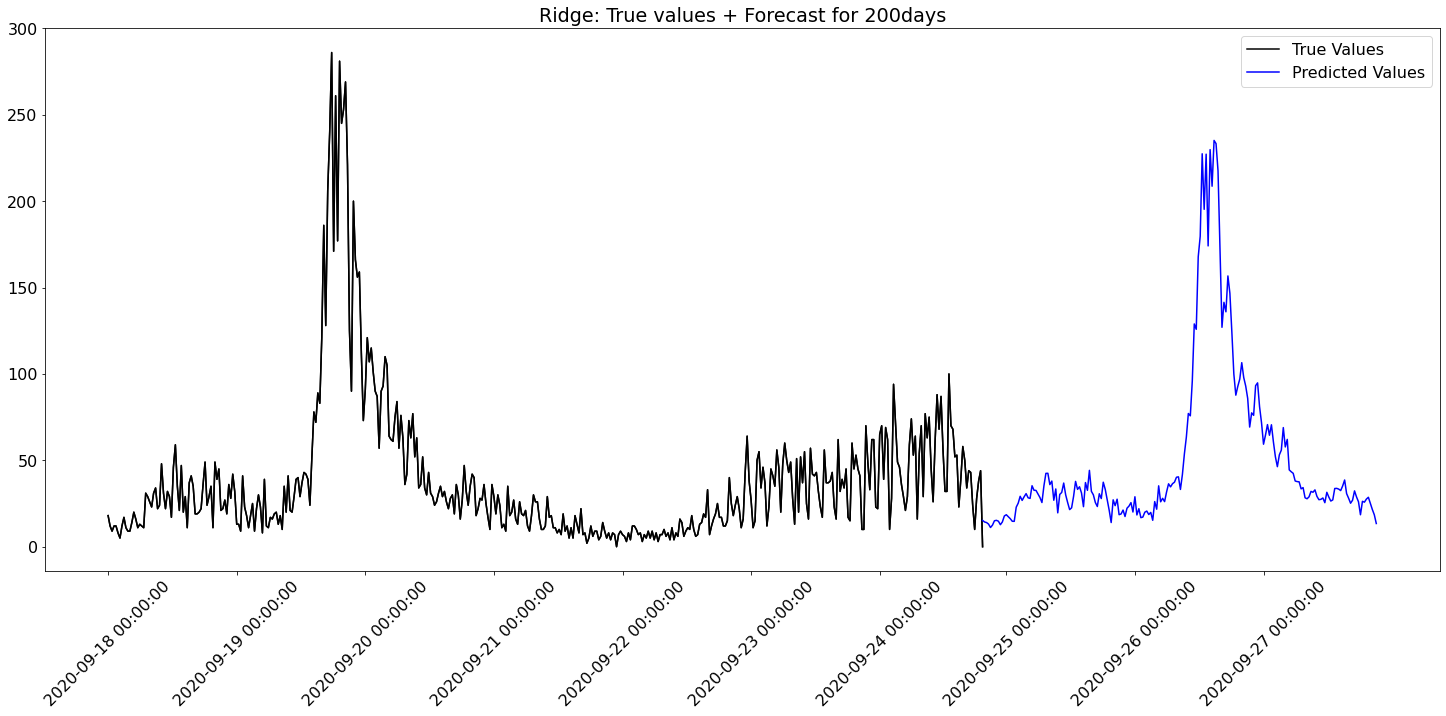

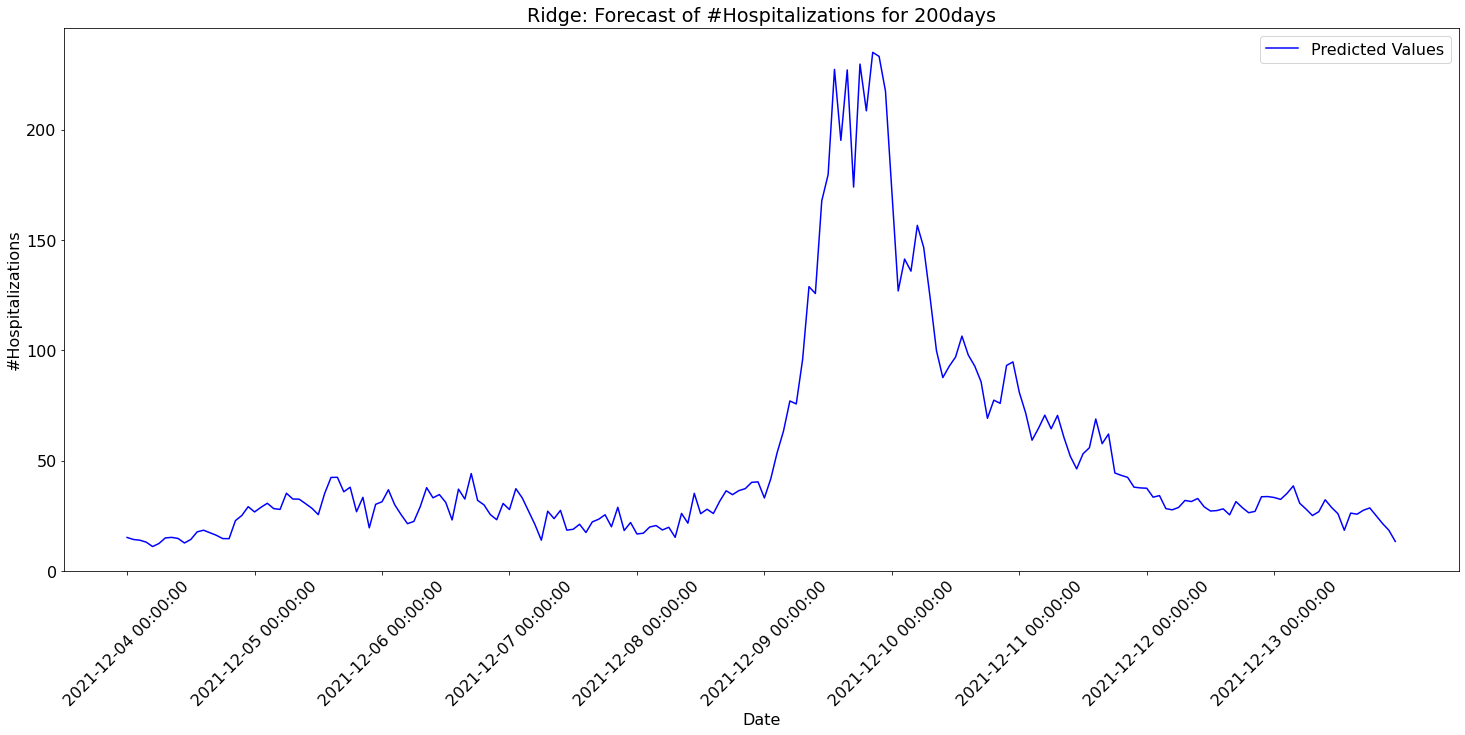

RMSE 200 days:  18.01949429219199


In [27]:
def train_predict_Ridge(q_step, stride, lag, dd):
  (t_full, ss, og_ss) = feature_selection(200, ending)

  q = 1
  og_tt = t_full[lag*dd+q::stride]
  day_sec = 86400000000000
  for j in range(0,q_step*day_sec, day_sec):
    XX = ss[0:ss.size - q - lag * dd:stride]
    for i in range(1,lag): 
      X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
      XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
    yy = ss[lag*dd+q::stride] #size of XX before column stacking
    # print("SS:",ss.size)
    # print("yy:",yy.size)
    tt = t_full[lag*dd+q::stride]
    # print(tt.size)
    from sklearn.model_selection import train_test_split 
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import Ridge 
    model = Ridge(fit_intercept=True, alpha=10).fit(XX[train], yy[train]) 
    # print(model.intercept_, model.coef_)

    y_pred = model.predict(XX) 
    yp = y_pred[y_pred.size-1]
    ss = np.append(ss, yp)
    np.append(tt, tt[tt.size-1] + day_sec)
    # print("tt:",tt.size)

  # print("XX:" ,XX.size)

  y_pred_2 = model.predict(XX)
  # print("tfull:",t_full)
  tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
  pred_num = tt_full2.size
  # print("ttfull2:",tt_full2)
  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='black')
  t_full_dates2 = pd.to_datetime(tt_full2)
  t_full_extended = np.append(t_full, tt_full2)
  t_full_dates = pd.to_datetime(t_full_extended)
  # print(t_full_dates)
  plt.plot(t_full, og_ss, color='black', label='True Values')
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue', label='Predicted Values')
  plt.xticks(t_full_extended, labels=t_full_dates, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.legend()
  plt.title('Ridge: True values + Forecast for ' +str(q_step)+ 'days')
  plt.show()
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue', label='Predicted Values')  
  plt.xticks(tt_full2, labels=t_full_dates2, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('#Hospitalizations')
  plt.title('Ridge: Forecast of #Hospitalizations for ' +str(q_step)+ 'days')
  plt.show()
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred_2)
  rmse = math.sqrt(mse)
  return rmse

rmse_30 = train_predict_Ridge(30, 1, 2, 1)
print("RMSE: ", rmse_30)

rmse_200 = train_predict_Ridge(200,1,3,1)
print("RMSE 200 days: ", rmse_200)


Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443


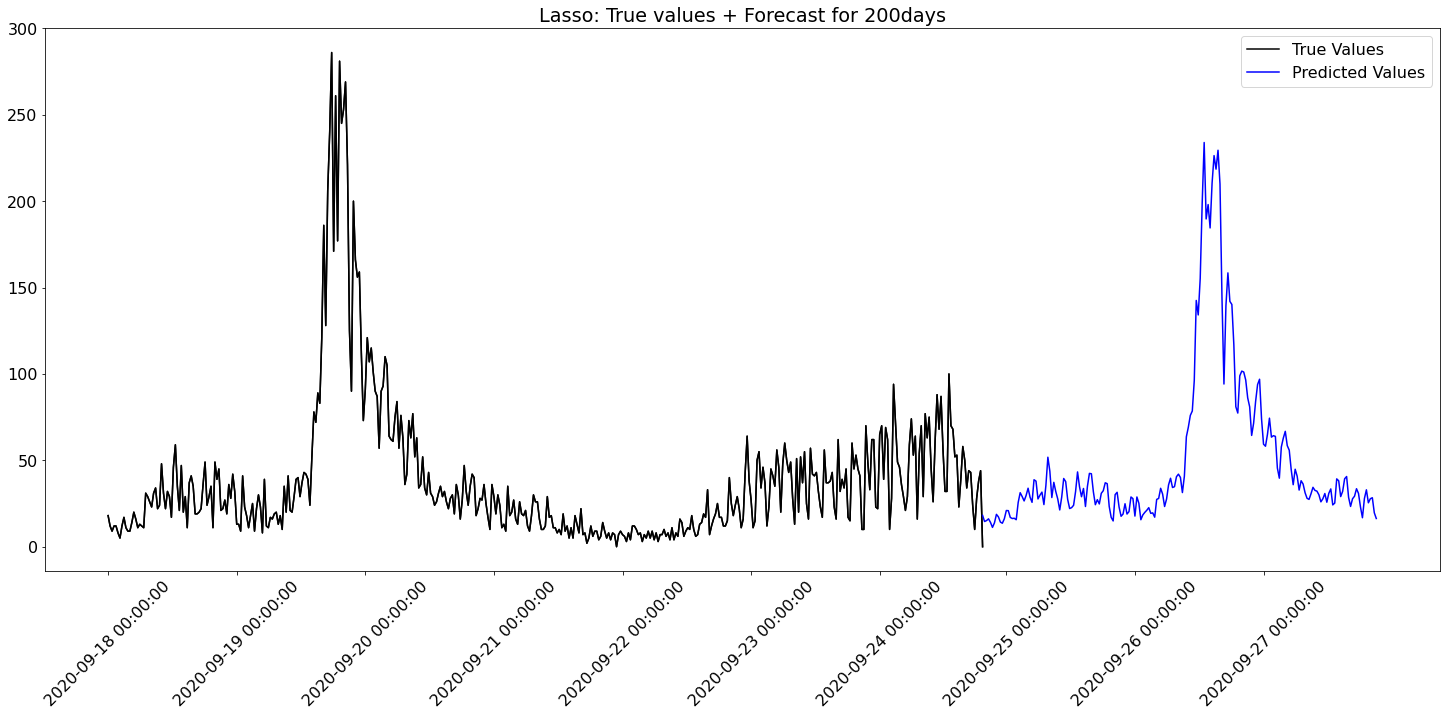

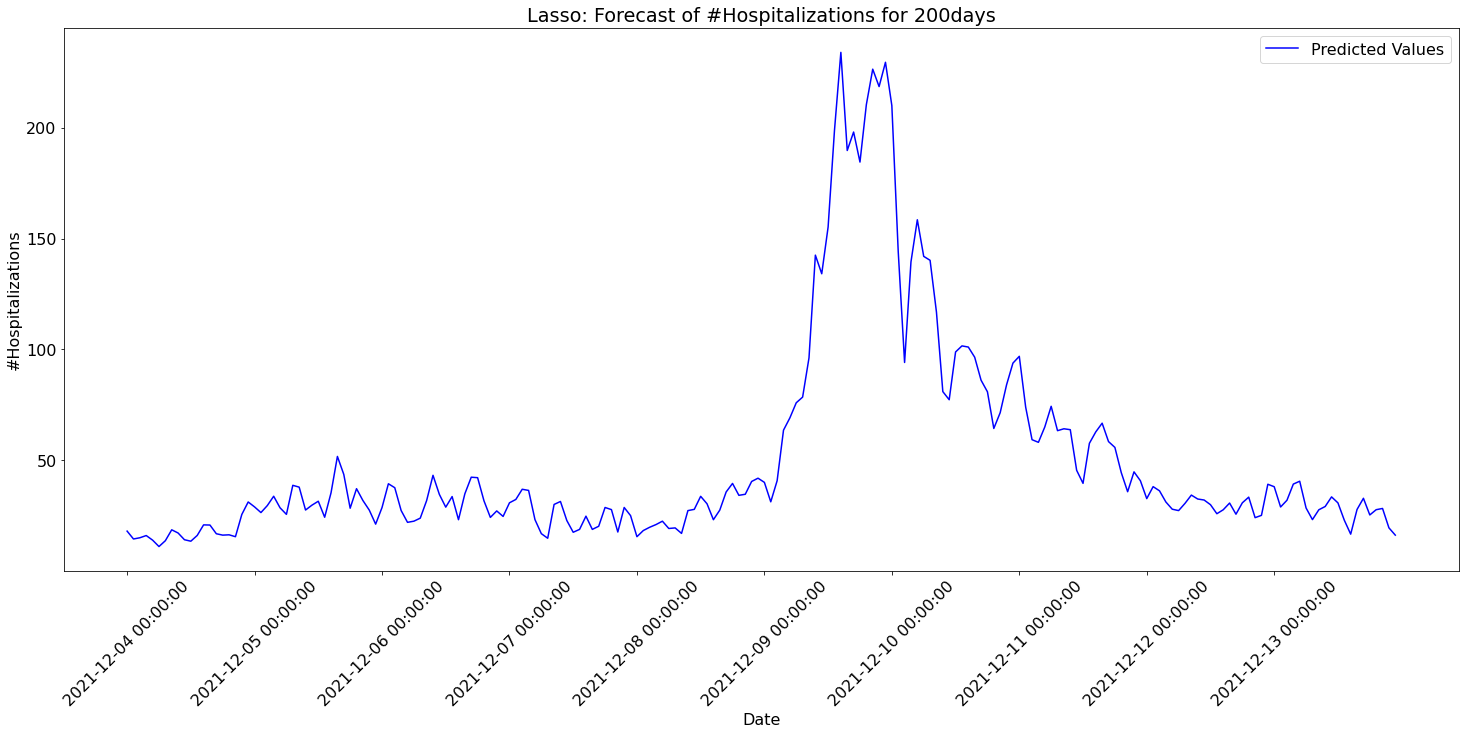

RMSE lasso 200: 18.617851253469514


In [28]:
def train_predict_Lasso(q_step, stride, lag, dd):
  # stride = stride
  # lag = lag #determines the feature vector size
  # dd = dd #number of samples in a day 
  (t_full, ss, og_ss) = feature_selection(200, ending)

  q = 1
  og_tt = t_full[lag*dd+q::stride]
  day_sec = 86400000000000
  for j in range(0,q_step*day_sec, day_sec):
    XX = ss[0:ss.size - q - lag * dd:stride]
    for i in range(1,lag): 
      X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
      XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
    yy = ss[lag*dd+q::stride] #size of XX before column stacking
    # print("SS:",ss.size)
    # print("yy:",yy.size)
    tt = t_full[lag*dd+q::stride]
    # print(tt.size)
    from sklearn.model_selection import train_test_split 
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import Lasso 
    model = Lasso(fit_intercept=True, alpha=50).fit(XX[train], yy[train]) 
    # print(model.intercept_, model.coef_)

    y_pred = model.predict(XX) 
    yp = y_pred[y_pred.size-1]
    ss = np.append(ss, yp)
    np.append(tt, tt[tt.size-1] + day_sec)
    # print("tt:",tt.size)

  # print("XX:" ,XX.size)

  y_pred_2 = model.predict(XX)
  # print("tfull:",t_full)
  tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
  pred_num = tt_full2.size
  # print("ttfull2:",tt_full2)
  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='black')
  t_full_dates2 = pd.to_datetime(tt_full2)
  t_full_extended = np.append(t_full, tt_full2)
  t_full_dates = pd.to_datetime(t_full_extended)
  # print(t_full_dates)
  plt.plot(t_full, og_ss, color='black', label='True Values')
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue', label='Predicted Values')
  plt.xticks(t_full_extended, labels=t_full_dates, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.legend()
  plt.title('Lasso: True values + Forecast for ' +str(q_step)+ 'days')
  plt.show()
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue', label='Predicted Values')  
  plt.xticks(tt_full2, labels=t_full_dates2, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('#Hospitalizations')
  plt.title('Lasso: Forecast of #Hospitalizations for ' +str(q_step)+ 'days')
  plt.show()
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred_2)
  rmse = math.sqrt(mse)
  return rmse

rmse_lasso_200 = train_predict_Lasso(200, 1, 2, 1)
print("RMSE lasso 200:", rmse_lasso_200)


In [ ]:
# def train_predict_LR(q_step, stride, lag, dd):
#   (t_full, ss, og_ss) = feature_selection(200, ending)

#   q = 1
#   ss = og_ss
#   og_tt = t_full[lag*dd+q::stride]
#   day_sec = 86400000000000
#   for j in range(0,q_step*day_sec, day_sec):
#     XX = ss[0:ss.size - q - lag * dd:stride]
#     for i in range(1,lag): 
#       X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
#       XX = np.column_stack((XX,X))
#     # print(XX.size) #will be size = lag * X_size
#     yy = ss[lag*dd+q::stride] #size of XX before column stacking
#     # print("SS:",ss.size)
#     # print("yy:",yy.size)
#     tt = t_full[lag*dd+q::stride]
#     # print(tt.size)
#     from sklearn.model_selection import train_test_split 
#     train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

#     from sklearn.linear_model import LogisticRegression
#     model = LogisticRegression(fit_intercept=True, penalty='l2',max_iter=10000).fit(XX[train], yy[train]) 
#     # print(model.intercept_, model.coef_)

#     y_pred = model.predict(XX) 
#     yp = y_pred[y_pred.size-1]
#     ss = np.append(ss, yp)
#     np.append(tt, tt[tt.size-1] + day_sec)
#     # print("tt:",tt.size)

#   # print("XX:" ,XX.size)

#   y_pred_2 = model.predict(XX)
#   # print("tfull:",t_full)
#   tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
#   pred_num = tt_full2.size
#   # print("ttfull2:",tt_full2)
#   plt.rcParams["figure.figsize"] = (25,10)
#   plt.plot(t_full, og_ss, color='black')
#   t_full_dates2 = pd.to_datetime(tt_full2)
#   t_full_extended = np.append(t_full, tt_full2)
#   t_full_dates = pd.to_datetime(t_full_extended)
#   # print(t_full_dates)
#   plt.plot(t_full, og_ss, color='black', label='True Values')
#   plt.plot(tt_full2, y_pred_2[:q_step], color='blue', label='Predicted Values')
#   plt.xticks(t_full_extended, labels=t_full_dates, rotation=45)
#   plt.locator_params(axis='x', nbins=10)
#   plt.legend()
#   plt.title('LogisticRegression: True values + Forecast for ' +str(q_step)+ 'days')
#   plt.show()
#   plt.plot(tt_full2, y_pred_2[:q_step], color='blue', label='Predicted Values')  
#   plt.xticks(tt_full2, labels=t_full_dates2, rotation=45)
#   plt.locator_params(axis='x', nbins=10)
#   plt.legend()
#   plt.xlabel('Date')
#   plt.ylabel('#Hospitalizations')
#   plt.title('LogisticRegression: Forecast of #Hospitalizations for ' +str(q_step)+ 'days')
#   plt.show()
#   plt.show()

#   from sklearn.metrics import mean_squared_error
#   mse = mean_squared_error(yy, y_pred_2)
#   rmse = math.sqrt(mse)
#   return rmse

# rmse_lr_10 = train_predict_LR(10, 1, 2, 1)
# print("rmse lr 200:", rmse_lr_10)


Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0
443
Start:  2020-09-18 00:00:00
End:  2021-12-05 00:00:00
Data sampling interval 86400000000000
1000000000.0


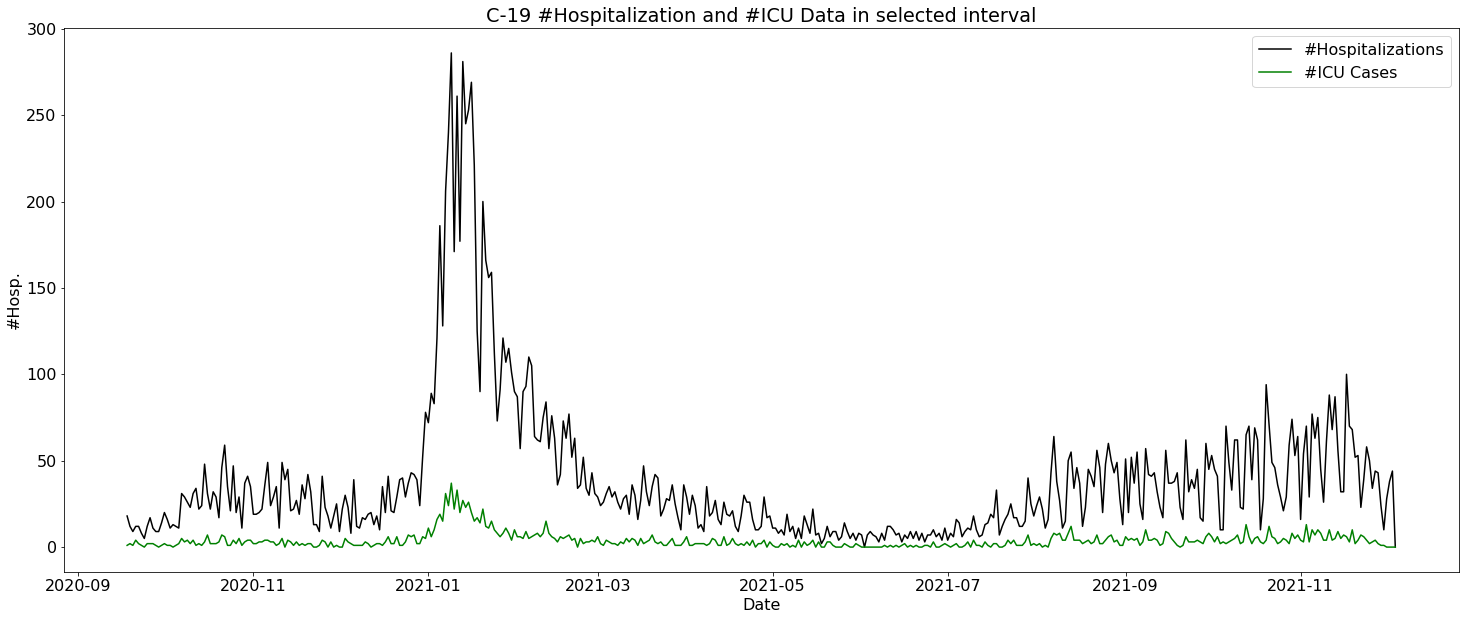

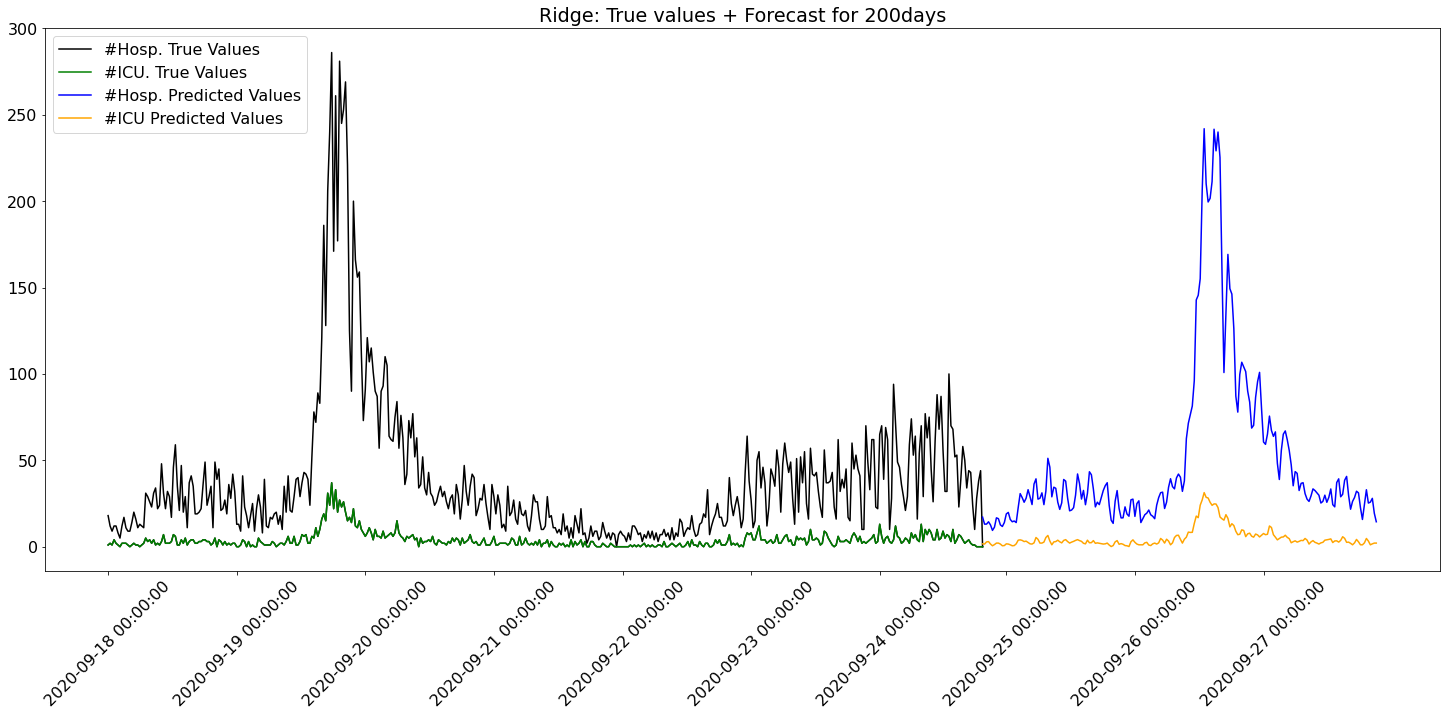

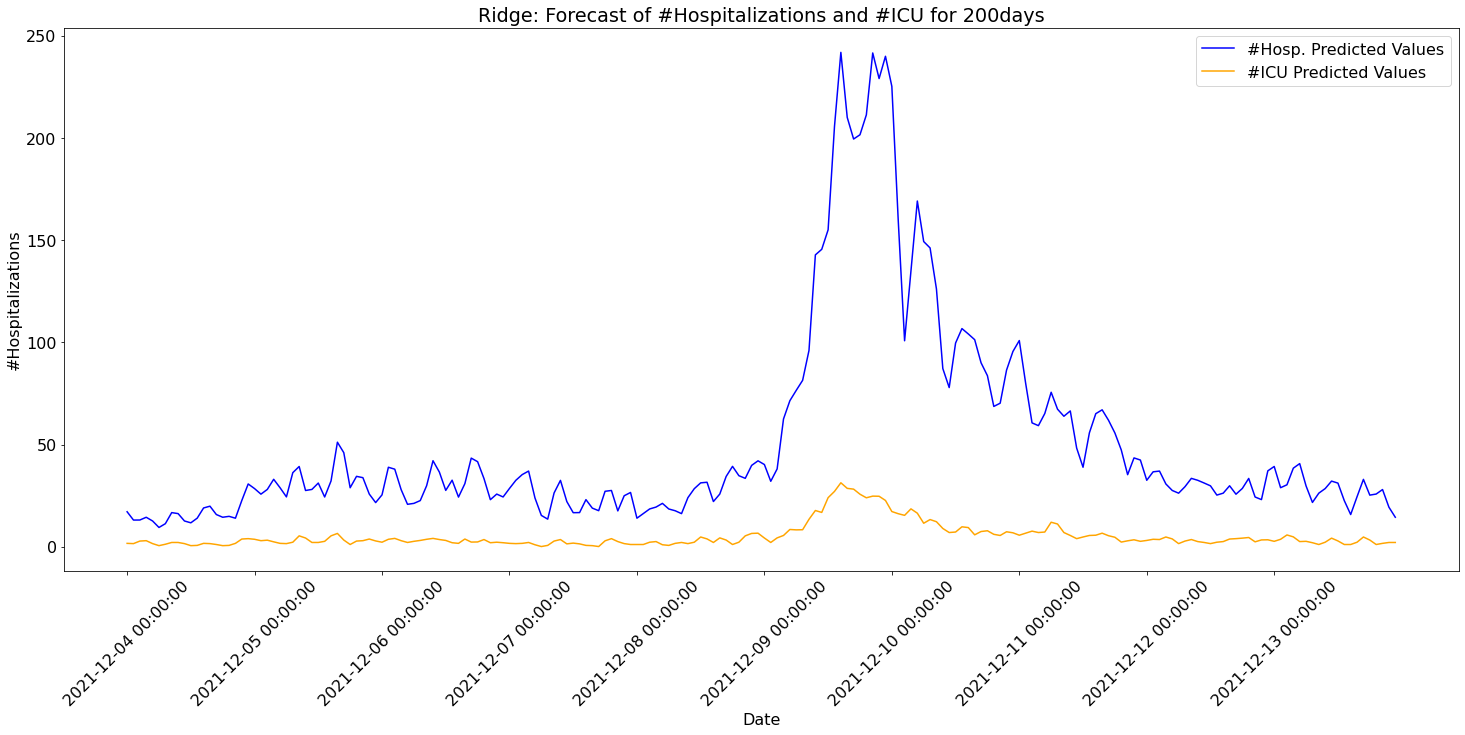

RMSE ICU 200:  18.672497030278418


In [29]:
def train_predict_ICU_Ridge(q_step, stride, lag, dd):
  (t_full, og_ss, ss) = feature_selection(200, ending)
  (t_full, icu_og_ss, icu_ss) = feature_selection_ICU(200, ending)

  plt.plot(df2.iloc[200:ending, 2], ss, color='black', label="#Hospitalizations")
  plt.plot(df2.iloc[200:ending, 2], icu_ss, color='green', label="#ICU Cases")
  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('#Hosp.')
  plt.title('C-19 #Hospitalization and #ICU Data in selected interval')
  plt.show()

  q = 1

  og_tt = t_full[lag*dd+q::stride]
  day_sec = 86400000000000
  #training for both #hosp. (col. 42) and #icu (col. 44)
  for j in range(0,q_step*day_sec, day_sec):
    XX = ss[0:icu_ss.size - q - lag * dd:stride]
    XX_icu = icu_ss[0:icu_ss.size - q - lag * dd:stride]

    for i in range(1,lag): 
      X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
      X_icu = icu_ss[i*dd:icu_ss.size - q - (lag-i)*dd:stride]

      XX = np.column_stack((XX,X))
      XX_icu = np.column_stack((XX_icu,X_icu))

    yy = ss[lag*dd+q::stride]
    yy_icu = icu_ss[lag*dd+q::stride]

    tt = t_full[lag*dd+q::stride]
    # print(tt.size)
    from sklearn.model_selection import train_test_split 
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import Ridge
    model = Ridge(fit_intercept=True, alpha=10).fit(XX[train], yy[train]) 
    model_icu = Ridge(fit_intercept=True, alpha=10).fit(XX_icu[train], yy_icu[train]) 
    # print(model.intercept_, model.coef_)

    y_pred = model.predict(XX)
    y_pred_icu = model.predict(XX_icu) 

    yp = y_pred[y_pred.size-1]
    yp_icu = y_pred_icu[y_pred_icu.size-1]

    ss = np.append(ss,yp)
    icu_ss = np.append(icu_ss, yp_icu)

    np.append(tt, tt[tt.size-1] + day_sec)
    # print("tt:",tt.size)

  # print("XX:" ,XX.size)

  y_pred_2 = model.predict(XX)
  y_pred_2_icu = model_icu.predict(XX_icu)

  tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
  pred_num = tt_full2.size
  # print("ttfull2:",tt_full2)
  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, icu_og_ss, color='black')
  t_full_dates2 = pd.to_datetime(tt_full2)
  t_full_extended = np.append(t_full, tt_full2)
  t_full_dates = pd.to_datetime(t_full_extended)
  # print(t_full_dates)
  plt.plot(t_full, og_ss, color='black', label='#Hosp. True Values')
  plt.plot(t_full, icu_og_ss, color='green', label='#ICU. True Values')
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue', label='#Hosp. Predicted Values')
  plt.plot(tt_full2, y_pred_2_icu[:q_step], color='orange', label='#ICU Predicted Values')
  plt.xticks(t_full_extended, labels=t_full_dates, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.legend()
  plt.title('Ridge: True values + Forecast for ' +str(q_step)+ 'days')
  plt.show()
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue', label='#Hosp. Predicted Values')  
  plt.plot(tt_full2, y_pred_2_icu[:q_step], color='orange', label='#ICU Predicted Values')

  plt.xticks(tt_full2, labels=t_full_dates2, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('#Hospitalizations')
  plt.title('Ridge: Forecast of #Hospitalizations and #ICU for ' +str(q_step)+ 'days')
  plt.show()
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred_2)
  rmse = math.sqrt(mse)
  return rmse

rmse_icu_200 = train_predict_ICU_Ridge(200, 1, 2, 1)
print("RMSE ICU 200: ", rmse_icu_200)

